In [6]:
import sys ; sys.path.append('../')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *

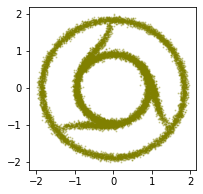

In [7]:
data = ToyDataset()
n_samples = 1 << 14
n_gaussians = 7

X, yn = data.generate(n_samples, 'diffeqml', noise=5e-2)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='olive', alpha=0.3, s=1)

In [8]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
train = data.TensorDataset(X_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True) 

In [9]:
class IntegralLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, s, x, dx):
        pass
    
    def set_target(self, y):
        pass

In [11]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )

from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device)) 

# stochastic estimators require a definition of a distribution where "noise" vectors are sampled from
noise_dist = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
# cnf wraps the net as with other energy models
cnf = CNF(f, trace_estimator=hutch_trace, noise_dist=noise_dist)
nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), sensitivity='adjoint', atol=1e-4, rtol=1e-4)

In [12]:
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

In [13]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1 
        x = batch[0] 
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        nde.nfe = 0
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

In [14]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=600)
trainer.fit(learn);

GPU available: True, used: False
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 8 K   

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 8 K   
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloa

/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..
Saving latest checkpoint..
